In [4]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import time
import numpy as np
import pickle

from sklearn.manifold import TSNE
from nltk.tokenize import sent_tokenize
from flair.embeddings import WordEmbeddings
from flair.data import Sentence
from nlp_surveillance.pipeline import RecommenderLabeling

In [5]:
X_transform = np.loadtxt('X_embed.csv', delimiter=',')

# Glove Embeddings

In [12]:
df = RecommenderLabeling().data_output()
X = df['extracted_text']
y = df['label']

# init embedding
glove_embedding = WordEmbeddings('en-news')
# preprocess to flair Sentence
sentences = [Sentence(sentence) for sentence in sent_tokenize(' '.join(X))]

# embed a sentence using glove.
for sentence in sentences:
    glove_embedding.embed(sentence)

In [17]:
words = []
embeddings = []
for sentence in sentences:
    for token in sentence:
        if not len(token.text)>12 and all(c.isalnum() for c in token.text) and sum(token.embedding)>1:
            words.append(token.text)
            embeddings.append(token.embedding.numpy())

In [43]:
with open("glove_trained_embeddings.pkl", "wb") as f:
    pickle.dump(list(zip(words,embeddings)), f)

In [6]:
with open("glove_trained_embeddings.pkl", "rb") as f:
    word_and_embeddings = pickle.load(f)

In [10]:
words, embeddings = map(list,zip(*word_and_embeddings))

In [14]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000)
tsne_results = tsne.fit_transform(embeddings[::1000])

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 211 samples in 0.002s...
[t-SNE] Computed neighbors for 211 samples in 0.009s...
[t-SNE] Computed conditional probabilities for sample 211 / 211
[t-SNE] Mean sigma: 0.860417
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.240685
[t-SNE] KL divergence after 1000 iterations: 0.518517


In [15]:
d = dict(zip(words, embeddings))

In [16]:
words_ = [k for k, _ in d.items()]
embeddings_ = [v for _, v in d.items()]

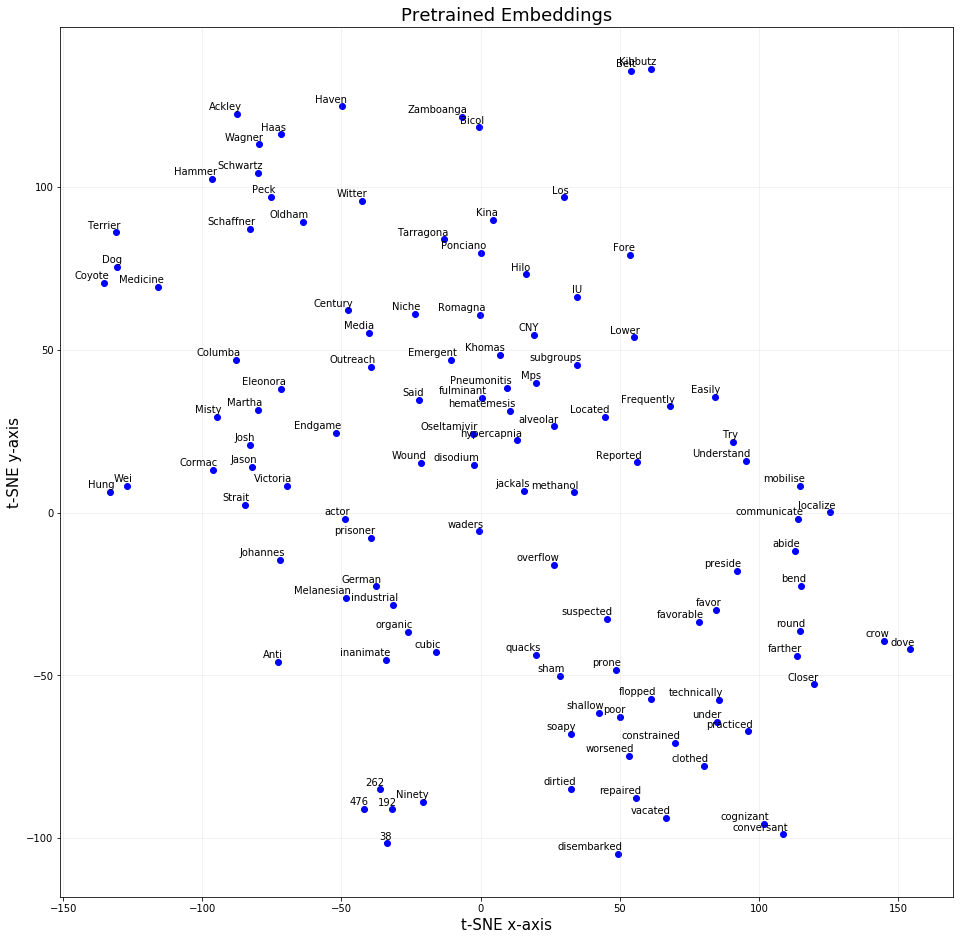

In [17]:
"Creates and TSNE model and plots it"
labels = words_[6::50]
values = embeddings_[6::50]


tsne_model = TSNE(perplexity=5, n_components=2, init='pca', n_iter=2500, random_state=12)
new_values = tsne_model.fit_transform(values)

x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])

plt.figure(figsize=(16, 16)) 
for i in range(len(x)):
    plt.scatter(x[i],y[i], c="blue")
    plt.annotate(labels[i],
                 xy=(x[i], y[i]),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
plt.xlabel("t-SNE x-axis", size=15)
plt.ylabel("t-SNE y-axis", size=15)
plt.grid(alpha=0.2)
plt.title("Pretrained Embeddings", size=18)
plt.savefig("t-sne_pre.pdf",format='pdf')
plt.show()
plt.show()

# Self-trained embeddings

In [20]:
import multiprocessing
import gensim
from gensim.models import Word2Vec
from nltk.tokenize import sent_tokenize
import re
import nltk
import matplotlib.cm as cm
import codecs

def train_word2vec(filename):
    data = gensim.models.word2vec.LineSentence(filename)
    return Word2Vec(data, size=100, window=1, min_count=5, workers=multiprocessing.cpu_count())

def prepare_for_w2v(filename_from, filename_to):
    raw_text = codecs.open(filename_from, "r").read()
    with open(filename_to, 'w', encoding='utf-8') as f:
        for sentence in nltk.sent_tokenize(raw_text):
            print(sentence.lower(), file=f)

In [24]:
prepare_for_w2v('extracted.txt', 'extracted_sentences.txt')

In [25]:
model_extracted_sentences = train_word2vec('extracted_sentences.txt')

2019-04-19 13:12:44,532 this function is deprecated, use smart_open.open instead
2019-04-19 13:12:46,119 this function is deprecated, use smart_open.open instead
2019-04-19 13:12:48,502 this function is deprecated, use smart_open.open instead
2019-04-19 13:12:50,727 this function is deprecated, use smart_open.open instead
2019-04-19 13:12:52,892 this function is deprecated, use smart_open.open instead
2019-04-19 13:12:55,026 this function is deprecated, use smart_open.open instead


In [26]:
words_self = []
embeddings_self = []
for word in list(model_extracted_sentences.wv.vocab):
    if word.isalnum() and len(word) < 12:
        embeddings_self.append(model_extracted_sentences.wv[word])
        words_self.append(word)

In [29]:
words_self_ = words_self[5::70]
embeddings_self_ = embeddings_self[5::70]

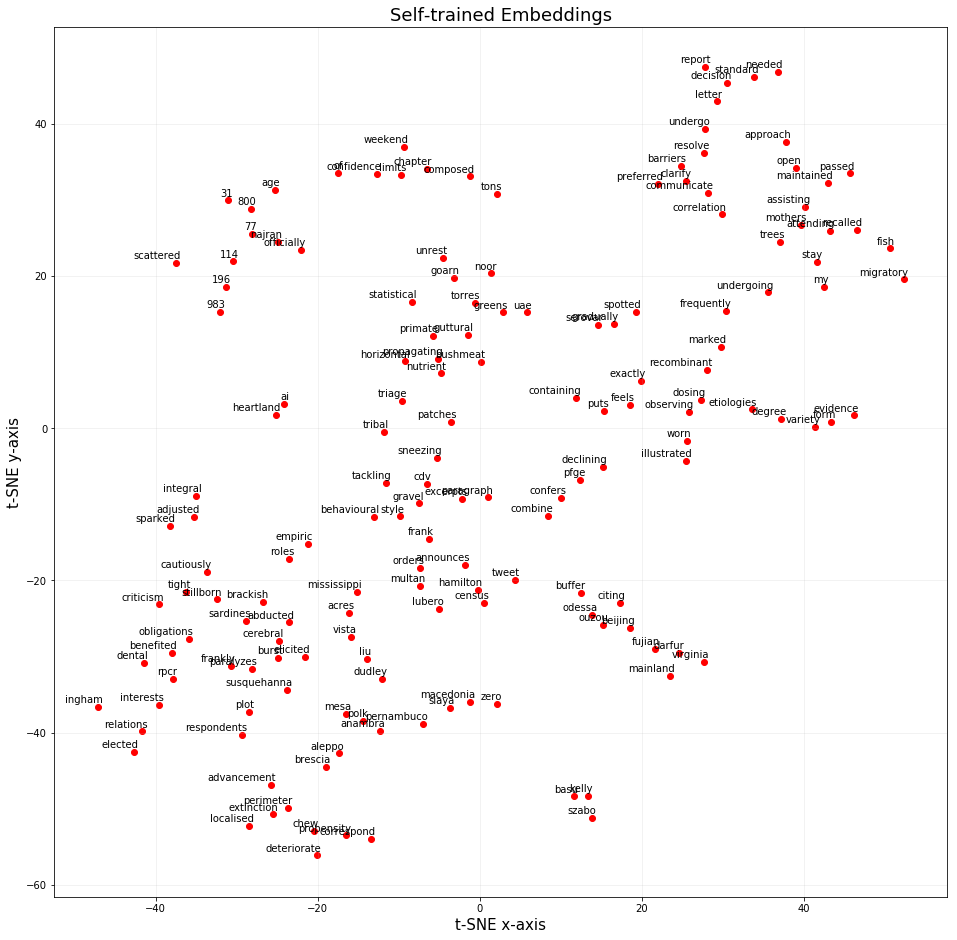

In [30]:
tsne_model_self = TSNE(perplexity=5, n_components=2, init='pca', n_iter=2500, random_state=12)
new_values_self = tsne_model.fit_transform(embeddings_self_)

x_self = []
y_self = []
for value in new_values_self:
    x_self.append(value[0])
    y_self.append(value[1])

plt.figure(figsize=(16, 16)) 
for i in range(len(x_self)):
    dot = plt.scatter(x_self[i],y_self[i], c="red")
    plt.annotate(words_self_[i],
                 xy=(x_self[i], y_self[i]),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
plt.xlabel("t-SNE x-axis", size=15)
plt.ylabel("t-SNE y-axis", size=15)
plt.grid(alpha=0.2)


plt.title("Self-trained Embeddings", size=18)
plt.savefig("t-sne_self.pdf",format='pdf')
plt.show()